In [ ]:
"""--------------------------------------------------------------------------
This script analyzes and classifies environmental indicators (noise pollution, access to green space, brigtness tempertature) 
and indicators of social status to assess environmental justice at city level. Spatial level of analysis are districts.
The code create maps and plots to visualize the results of the analysis. It
saves a csv file with detailed statistics and results of the analyis
------------------------------------------------------------------------------"""

#### import libraries

In [ ]:
import geopandas as gpd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import cartopy.crs as ccrs
import pandas as pd
from scipy.stats import zscore
import contextily as cx
from cartopy.feature import ShapelyFeature

In [ ]:
#makes plot interactive
plt.ion()

In [ ]:
# loads all of the required data to calculate the social indicator
admin = gpd.read_file("data/Stadtteile_Hamburg.shp") # boundary dataset 
stats = pd.read_csv("data/statistics_HH21.csv",encoding="utf-8", delimiter=";",decimal="." ) # social statistics

# loads all of the required data to calculate the environmental indicators
noise = gpd.read_file("data/Laermkarten_HH_2018-11-19.shp")#noise data set
buildings = gpd.read_file('data/residential_buildings_HH.shp') #building dataset
green_areas = gpd.read_file("data/Oeffentliche_Gruenanlage_Hamburg.shp")#green areas dataset
brightnesstemp =pd.read_csv("data/temp_stats.csv",encoding="utf-8", delimiter=";",decimal="," )

#### Functions used in the script

In [ ]:
"""------- Function to reproject the datasets----------------"""
def reproject_to_local_epsg(gdf):
    """ Reprojects the dataframe to epsg=25832 for Hamburg. EPSG 25832 can be changed by users
    Input: dataframe
    
    Returns:
    A dataframe, reprojected to the target crs
    Prints out the crs of the original and the resulting crs of the reprojection

    """
    print('Original CRS:', gdf.crs)

    gdf_reproj = gdf.to_crs(epsg=25832)    # Reprojects the GeoDataFrame to EPSG 25832
    print('Reprojected CRS:', gdf_reproj.crs)

    return gdf_reproj

In [ ]:
"""------------------------- Functions to classify the indicators-----------------------"""

def percentile_5(gpd, col_name, percentiles): # used for all environmental indicators / indicators taking 1 column as input
    """Classifies the dataframe into 5 equal percentiles 

    Parameters: 
        gpd : geodataframe, 
        col_name: column of indicator used for classification
        percentiles : number of quantiles used for classification "5" : MUST be the same length as the labels
        labels: values resulting from the classification from 0-4 (e.g. 0= lowest 20th quantile of mean / to  - 4 within highest 20th quantile)
        
    Returns: 
    A classified geodataframe that saves the results of the classification in a new column with the name extension _percentile. 
    The new column contains the values from 0-4
    
    Apply the function: 
    Example: percentile_5(dataframe, 'columNname',5)"""   
    
    gpd[col_name + '_percentile']  = pd.qcut(gpd[col_name], percentiles, labels=[0, 1, 2, 3, 4]) 

    return gpd


In [ ]:
"""-----Function to classify the dataframe for use of multiple columns--- """

def percentile_multi(gdf, col_names, percentiles): # used for social inidator in this code
    """Classifies the dataframe into 5 equal percentiles. Takes as input multiple columns and the sum of these
    
    Parameters:
        gdf: geodataframes to classify
        col_names: colums used for classification
        percentiles: number of percentiles used for classification
        labels: values resulting from classification 0-4 (same as for "function percentile_5")
    
    Returns:
        A classified dataframe which saves the results of the classification into a new column called "qt_soc_stats"
        The new column contains the values from 0-4 and constitues the sum of colums used for calculation
        
    Apply the function:
        Example: percentile_multi(dataframe, ['col1', 'col1'], 5)
    """
    sum_col = gdf[col_names].sum(axis=1)
    gdf['qt_soc_stats'] = pd.qcut(sum_col, percentiles, labels=[0, 1, 2, 3, 4])
    return gdf.head()


In [ ]:
"""-----Function to add status string column to classified data --- """

def add_status_column(df, perc_col):#The function will be used for all of the different indicators)
    """The function adds a text column to the dataframe based on the classification result

    Parameters: 
        df : dataframe used for the classification: needs to be the same already used in the percentile_5 function 
        
    Returns:
        A dataframe with a new column called "status" containing strings with the values from "very low" to "very high"
        Assignes the names based on the values in the perc_col
        
    Apply the functin:
        Example: add_status_column(dataframe, 'columnName') # has to take the classified column:result of func percentile as input

    """
    df['status'] = ['very low' if x == 0 else  #creates the new column "status and then adds text description to the corresponding value"
                   'low' if x == 1 else
                   'medium' if x == 2 else
                   'high' if x == 3 else
                   'very high' for x in df[perc_col]]

    return df.head()


In [ ]:
"""-----Function to create map--------------- """

# function to define parameters for mapping of indicators
def plot_stats(gdf, title, color,output_path):   
    """ The function creates a map to visualize the ranking of each classified indicator
    
    Parameters: 
        gdf : dataframe used for the map
        title: title to be displayed on the map
        color: allows the user to specify colorbar used to visualize the map
        output_path: output_path to save the map with unique name 
        
        IMPORTANT: gdf for plotting has to contain a categorial column called "status"
        
    Returns:
        A coropleth map visualizing the ranking of each district by percentile which is the result of the classification
        The map uses the "status" column representing the result of the classification for each indicator
        The percentile ranking is ordered in ascending order from very low to very high  
        The map displays a legend, basemap and allows distinct colormaps and titles based on the input parameters
        The map is automatically saved in png format
        
    Apply the functin:
        Example: plot_stats(your gdf,"title goes here", "color")

    """    
    status_order = ['very low', 'low', 'medium', 'high', 'very high'] # order used for plotting

    # convert the status column to a categorical variable with the defined order
    gdf['status'] = pd.Categorical(gdf['status'], categories=status_order, ordered=True) 

    # sorts the values
    gdf = gdf.sort_values('status')
    
    # Creates a figure and defines the size 
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plots the data using the the status column 
    gdf.plot("status", cmap=color, legend=True, ax=ax) 
    
    legend = ax.get_legend()
    legend.set_title("Percentile Ranking") # adds the legend title
        
    # Sets the title and style of the plot
    ax.set_title(title, fontweight="bold", fontsize=14, color="#444444")
    
    #add basemap
    cx.add_basemap(ax,source=cx.providers.Stamen.TonerLite)

    #adds the district name to the plot and defines some style parameters
    gdf.apply(lambda x: ax.annotate(text=x['district'], xy=x.geometry.centroid.coords[0], ha='center', color="grey", size=7), axis=1)

    ax.set_axis_off()
    
    fig.savefig(output_path, dpi=300)

    # Displays the plot
    plt.show()

# 1)  Social Indicator
clean and filter the data 

In [ ]:
#rename the columns to english
stats.columns = ['district','inhabitants', 'pop<18','%<18', 'pop>65y','%>65', 'foreignResidents', 'migration_backg', 'hh','pp_size','hh_kids', '%hh_kids','areakm2', 'pop_density','working_pop', '%working_pop', 'unemployed','%unemployed','unemployed<18','%unemployed<18', 'unemployed>65', '%unemployed>65','social_benefits', '%social_benefits','social_housing', '%social_housing']

In [ ]:
#join the statistics  with the shapefile of administrative boundaries 
admin_pop = pd.merge(admin,stats, left_on='stadtteil_', right_on='district', how = 'inner')
# drop unecessary columns in the admin dataset
admin_pop.drop(columns=['OBJECTID','bezirk', 'stadttei_1', 'stadttei_2','pp_size', '%<18', 'hh','foreignResidents', 'migration_backg','pop<18','hh_kids', '%hh_kids', 'pop>65y', 'unemployed<18','unemployed>65','working_pop', 'social_benefits','social_housing' ],axis=1, inplace=True)

In [ ]:
# Subset the dataframe so that only columns relevant to the further analysis (social status) are maintained
# null values are droppped to enable calculation
social_stats = admin_pop[['%unemployed','%social_benefits','%social_housing','%unemployed>65' ]].dropna()
#code then checks standard deviation 
social_stats.std()

In [ ]:
# Uses Scipy Library to calculate the z-score to normalize values  
z_scores_admin_pop = social_stats[['%unemployed','%social_benefits','%social_housing','%unemployed>65']].apply(zscore)
print(z_scores_admin_pop.std()) # show the std after calculation of z-score

#### Classification of social statistics 

In [ ]:
# apply the function to classify the data using multiple columns on the results of the z_score calculation
percentile_multi(z_scores_admin_pop, ['%unemployed', '%social_benefits', '%social_housing', '%unemployed>65'], 5);

In [ ]:
# apply "add_status_column" function to add the status in text format
add_status_column(z_scores_admin_pop, 'qt_soc_stats') 

In [ ]:
#rename the newly calculated columns to differentiate from columns of original dataset
z_scores_admin_pop.columns = ['%unemployed_z','%social_benefits_z', '%social_housing_z','%unemployed>65_z','qt_soc_stats', 'status']

In [ ]:
#merge the social statistics to the admin dataframe to be able to plot  data later 
admin_socstats = pd.merge(admin_pop, z_scores_admin_pop, left_index=True, right_index=True) 
#drop the column with the "old statistics"
admin_socstats.drop(columns=['%unemployed','%social_benefits','%social_housing','%unemployed>65']);

# 2) Environmental Indicators
Uses noise, green areas, surface temperature? as environmental indicator)

In [ ]:
# apply "reproject_to_local_epsg" function to all the dataframe to convert CRS
admin_pop_reproj = reproject_to_local_epsg(admin_pop)
noise_reproj = reproject_to_local_epsg(noise)
housing_reproj = reproject_to_local_epsg(buildings)
green_areas_reproj = reproject_to_local_epsg(green_areas)
boundaries_reproj = reproject_to_local_epsg(admin)

## a)  Green areas - access to and distribution
Analyses distribution of green areas per district and area / inhabitant

In [ ]:
#delete  values with code 10 = playground according to ALKIS key(official cadastre information system)
green_areas_reproj = green_areas_reproj[green_areas_reproj.nutzung != 10] # nutzung = usage
#drop unimportant columns from the dataset
green_areas_reproj.drop(columns=['dgpkey', 'veroeffent','gemarkung', 'ortsteil', 'nutzung', 'nutz_code' ,'herrichtun', 'verwaltung','flaeche_qm', 'gesamtanla','aktualitae','idnr','belegenh_1','belegenhei','quelle_dat', 'stand'],axis=1, inplace=True)

#### Calculation of statistics of green areas

In [ ]:
# Calculate the sum of the area  statistics for green areas per district (district = stadtteil)
green_area_sum = green_areas_reproj.groupby(['stadtteil'])['flaeche_ha'].sum().reset_index() # group the dataset
green_area_sum.rename(columns={'flaeche_ha': 'green_area_total_ha'}, inplace=True) # translate column name to english

# Calculate mean green space area per district
green_area_mean = green_areas_reproj.groupby(['stadtteil'])['flaeche_ha'].mean().reset_index() 
green_area_mean.rename(columns={'flaeche_ha': 'green_area_mean_ha'}, inplace=True)

# Calculate the count of green spaces per district=  "bennenung" = unique name of green area
green_space_count = green_areas_reproj.groupby(['stadtteil'])['benennung'].count().reset_index()
green_space_count.rename(columns={'benennung': 'green_space_count'}, inplace=True)

# Combine the statistics into one dataframe using the stadtteil column
green_stats = pd.merge(green_area_sum, green_area_mean, on='stadtteil')
green_stats = pd.merge(green_stats, green_space_count, on='stadtteil')


In [ ]:
# Calculate the percentage of green space from total area of the district. "flaeche_ha" = area of individual polygons
green_stats['perc_green_area'] = green_areas_reproj['flaeche_ha'] / green_areas_reproj['geometry'].area * 100;

In [ ]:
# calculate the area per inhabitant  using the column "inhabitants" from the admin_pop_reproj dataframe
green_stats = green_stats.merge(admin_pop_reproj[['stadtteil_', 'inhabitants']], left_on='stadtteil', right_on='stadtteil_', how='left')
#green_stats.drop('district', axis=1, inplace=True)

In [ ]:
#calculate area / inhabitant and save the results in a new column
green_stats['area_per_inhbt'] = green_stats['inhabitants'] / green_stats['green_area_total_ha']
green_stats.head()

In [ ]:
#check std of relevant values
green_stats[['area_per_inhbt','perc_green_area' ]].std()

In [ ]:
#drop null values 
green_stats = green_stats.dropna(subset=['area_per_inhbt'])
#compute  z-score for the variables used for calculation from the  greenstats data set 
z_scores_green_stats = green_stats[['area_per_inhbt','perc_green_area' ]].apply(zscore)

#rename columns to distinguish from columns in original dataset
z_scores_green_stats = z_scores_green_stats.rename(columns={'area_per_inhbt': 'z_area_per_inhbt', 'perc_green_area': 'z_perc_green_area'})
#check the std after z-score has been applied
z_scores_green_stats[['z_area_per_inhbt','z_perc_green_area' ]].std()

In [ ]:
# Concatenate the original dataframe with the z-score dataframe
green_stats_zscore = pd.concat([green_stats, z_scores_green_stats], axis=1)
# drop  original column names: perc_green_area and _area_per_inhb
green_stats_zscore = green_stats_zscore.drop(['area_per_inhbt', 'perc_green_area'], axis=1)


#### Classification of green area statistics

In [ ]:
#apply "percentile_5" function to classify the green_stats data into equal percentiles based on 'area_per_inhbt' column
percentile_5(green_stats_zscore, 'z_area_per_inhbt',5);

In [ ]:
# apply "add_status_column" function using the classified "_percentile column"
add_status_column(green_stats_zscore, 'z_area_per_inhbt_percentile')

In [ ]:
#merge statistics with a subset of the reprojected admin dataframe to enable ploting
admin_subset = admin_pop_reproj[['district', 'geometry']]

admin_greenstats = pd.merge(admin_subset, green_stats_zscore, left_index=True, right_index=True);


## b) Noise Pollution 
For the noise indicator the assessment aims to identify the area of houses affected by noise and noiseclass /  district  

Analysis, filter and cleaning of the housing dataset

In [ ]:
#check data type of column "gebaeudefu" which indicates usage of buildings 
housing_reproj['gebaeudefu'] = housing_reproj['gebaeudefu'].astype(int)# convert the column to integer to enable calculations

#drop uninmportant columns in the dataset
housing_reproj.drop(columns=['anzahlDerU', 'lageZurErd', 'dachart', 'SHAPE_Leng'],axis=1, inplace=True)

In [ ]:
# use geopandas overlay method and interesect operation to determine where the noise layer intersects with the house layer 
houses_noise = gpd.overlay(housing_reproj, noise_reproj, how='intersection')

In [ ]:
#translate column names to English
houses_noise = houses_noise.rename(columns={'name': 'noiseclass', 'anzahlDerO': 'floors', 'grundflaec':'house_area'})

In [ ]:
# join the dataframe to the admin dataset to plot 
admin_noisestats = gpd.sjoin(admin_pop_reproj, houses_noise)

#### Calculation of Statistics

In [ ]:
#group the dataset to get the number of houses per noiseclass and district
houses_noiseclass = admin_noisestats.groupby(['district', 'noiseclass'])['OBJECTID'].count().reset_index()
houses_noiseclass.head()

In [ ]:
# mulitply the number of houses with the house area 
admin_noisestats['total_area'] = admin_noisestats['OBJECTID'] * admin_noisestats['house_area']

In [ ]:
# multiply the house area with the number of floors to get the total affected residential housing area by noiseclass
#convert it to sqkm
admin_noisestats['area_floors']=admin_noisestats['total_area']*admin_noisestats['floors'].astype(int)/1000000

In [ ]:
# convert the noiseclass to an integer
admin_noisestats['noiseclass'] = admin_noisestats['noiseclass'].astype(int)

In [ ]:
#weight the area by noiseclass in view of severity from low to high (increase by 0.5)
weights = {0: 0.5, 1: 1, 2: 1.5, 3: 2, 4: 2.5} # dictionary to define the weights
#use the pandas.map function to assign the weights and saves results in new column
admin_noisestats['weighted_area'] = admin_noisestats['area_floors'] * admin_noisestats['noiseclass'].map(weights) 

In [ ]:
#group data by district and weighted area
noisestats_weighted = admin_noisestats.groupby('district')['weighted_area'].sum().reset_index()
#admin_noisestats.head() # recommended to not display the output due to its size

In [ ]:
#apply function thats classifies dataframe into percentiles based on the weighted_area column
percentile_5(noisestats_weighted, 'weighted_area',5);

In [ ]:
# apply the "add_status_column" function
add_status_column(noisestats_weighted, 'weighted_area_percentile')


In [ ]:
#merge the noise statistics  with a subset of the reprojected admin data to plot later
noisestats_merged = pd.merge(admin_subset, noisestats_weighted, left_index=True, right_index=True)
noisestats_merged.rename(columns={'district_x': 'district'}, inplace=True)
noisestats_merged.drop('district_y', axis=1, inplace=True)

## C) Brigthness Temperature

In [ ]:
#join the statistics  with the shapefile of administrative boundaries 
temp_bounds = pd.merge(boundaries_reproj,brightnesstemp, on="stadtteil_")

#### Classification of temperature brightness data

In [ ]:
#apply function thats classifies dataframe into percentiles based on the classified column
percentile_5(temp_bounds, 'MEDIAN',5);

In [ ]:
# apply the "add_status_column" function to add text description
add_status_column(temp_bounds, 'MEDIAN_percentile');

In [ ]:
#rename district column for use in the plotting function 
temp_bounds=temp_bounds.rename(columns={"stadtteil_":"district"})

In [ ]:
temp_bounds.head()

# 3) Combined Analysis of Individual Indicators
This section combines the individual indicators to assess the spatial relation between the individual indicators

In [ ]:
#prepare for merge: subset the social stats dataset to keep only relevant columns for merge
soc_subset = admin_socstats[["bezirk_nam","district","geometry", "status","qt_soc_stats", "%unemployed","%social_benefits","%social_housing"]]
#rename status columns in all dataframes to avoid duplications 
soc_subset=soc_subset.rename(columns={"status":"status_soc"})
green_subset=green_stats_zscore.rename(columns={"status":"status_greens"})
noisestats_subset=noisestats_merged.rename(columns={"status":"status_noise"})
noisestats_subset.drop(columns=['geometry']);
tempstats_subset=temp_bounds.rename(columns={"status":"status_temp_b"})
tempstats_subset.drop(columns=['PCT90','RANGE']);

In [ ]:
#merge the statistics data set to have one single dataframe for relevant statistics as output
stats_merged = green_subset.merge(soc_subset, left_on='stadtteil', right_on='district', how='inner')
stats_merged = stats_merged.merge(noisestats_subset, left_on='district', right_on='district', how='right');
stats_merged = stats_merged.merge(tempstats_subset, left_on='district', right_on='district', how='right');

In [ ]:
#subset dataframe to the classified
stat_indicators=stats_merged[['district','weighted_area_percentile','z_area_per_inhbt_percentile','qt_soc_stats','status_greens','status_noise','MEDIAN_percentile','status_temp_b']]

In [ ]:
print(stat_indicators[['district','weighted_area_percentile', 'z_area_per_inhbt_percentile', 'qt_soc_stats','MEDIAN_percentile']].dtypes)

In [ ]:
#create copy of data 
stat_indicators_copy = stat_indicators.copy()

In [ ]:
#convert categorial variable back to int to be able to perform sum calculations
cat_to_int = ['weighted_area_percentile', 'z_area_per_inhbt_percentile', 'qt_soc_stats', 'MEDIAN_percentile']
for col in cat_to_int:
    stat_indicators_copy[col] = pd.to_numeric(stat_indicators_copy[col], errors='coerce').fillna(0).astype(int) 
    #converts the type and fills the null values 

In [ ]:
#calculate the sum of the environmental indicators per district
environmental_burden= stat_indicators_copy.groupby('district')[['weighted_area_percentile', 'z_area_per_inhbt_percentile','MEDIAN_percentile']].sum()
environmental_burden['env_multiple_burden'] = environmental_burden.sum(axis=1)
environmental_burden = environmental_burden.reset_index()
#add the social status indicatur
environmental_burden['social_status'] = stat_indicators_copy['qt_soc_stats']
#calculate the sum of the combined environmentalindicator and social status indicator
environmental_burden['combined_indicators'] = environmental_burden['env_multiple_burden'] + stat_indicators_copy['qt_soc_stats']

### Classification of combined statistics

In [ ]:
#classify both new columns in 5 percentiles 
environmental_burden['env_multiple_burden_percentile'] = pd.qcut(environmental_burden['env_multiple_burden'], q=5, labels=False)
environmental_burden['combined_indicators_percentile'] = pd.qcut(environmental_burden['combined_indicators'], q=5, labels=False)

In [ ]:
#apply the "add_status_column function" to the total burden column
add_status_column(environmental_burden,'combined_indicators_percentile',)
environmental_burden.head()

In [ ]:
# merge the combined statistics with admin data containing the social indicator and geometry column
admin_env_soc = environmental_burden.merge(admin_socstats[['district', 'qt_soc_stats', 'geometry']], on='district', suffixes=('_env', '_soc'))
#transform the data back to geodataframe
combined_indicators = gpd.GeoDataFrame(admin_env_soc, geometry='geometry')
combined_indicators.head()

In [ ]:
#merge the columns of the combined indicators to the stats_merged dataframe drop NaN values
combined_indicators_subset = combined_indicators[['env_multiple_burden','combined_indicators', 'env_multiple_burden_percentile','combined_indicators_percentile']]
stats_merged = pd.concat([stats_merged, combined_indicators_subset], axis=1)
stats_merged.dropna(axis=1);

# 4)  Visualizations of Indicators
Create maps and plots for the different indicators

In [ ]:
## apply the "plot_stats" function to plot the social status indicator 
plot_stats(admin_socstats,"Hamburg Environmental Justice Map - Indicator: Social Status", "Oranges", "./output/map_social_status.png")

In [ ]:
#apply the "plot_stats" function to plot the green supply indicator 
plot_stats(admin_greenstats, "Hamburg Environmental Justice Map - Indicator: Green Area Supply", "YlGn", "./output/map_green_supply.png")

In [ ]:
#apply the "plot_stats" function to plot the noise pollution indicator 
plot_stats(noisestats_merged, "Hamburg Environmental Justice Map - Indicator: Noise Pollution", "Blues","./output/map_noise_pollution.png" )

In [ ]:
#apply the "plot_stats" function to plot the thermal burden indicator 
plot_stats(temp_bounds, "Hamburg Environmental Justice Map - Indicator: Thermal Burden", "YlOrRd", "./output/map_thermal_burden.png")

In [ ]:
#apply the "plot_stats" function to plot the combined indicator (total of combined indicators)
plot_stats(combined_indicators, "Hamburg - Integrated Environmental Burden & Social Status Index", "RdPu","./output/map_integrated_indicator.png" )

## a) Plots 
Create plots to visualize distribution of cateogrial variables

In [ ]:
#counts the number of occurances of each individual indicator per percentile ranking
counts_occurrence = pd.DataFrame({
    'qt_soc_stats': stats_merged['qt_soc_stats'].value_counts(),
    'weighted_area_percentile': stats_merged['weighted_area_percentile'].value_counts(),
    'z_area_per_inhbt_percentile': stats_merged['z_area_per_inhbt_percentile'].value_counts(),
    'MEDIAN_percentile': stats_merged['MEDIAN_percentile'].value_counts(),

})
counts_occurrence

#rename column names to make it nicer for plotting
counts_occurrence=counts_occurrence.rename(columns={"qt_soc_stats":"Social_status","weighted_area_percentile":"Noise Pollution","z_area_per_inhbt_percentile":"Green Areas ","MEDIAN_percentile":"Thermal Burden" })


In [ ]:
counts_occurrence.head()

<Figure size 640x480 with 0 Axes>

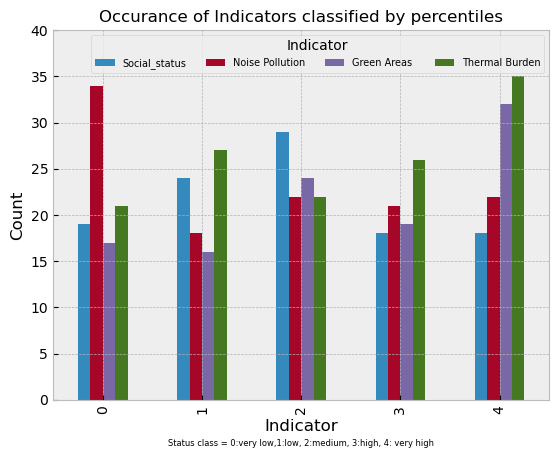

In [69]:
## create plot with  occurances
plt.figure()
plt.style.use('bmh')

counts_occurrence.plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('Indicator')
plt.title('Occurance of Indicators classified by percentiles', fontsize=12)
plt.ylim(0, 40)
plt.legend(title='Indicator', fontsize=7 ,ncols=4)
plt.text( 2, -5, 'Status class = 0:very low,1:low, 2:medium, 3:high, 4: very high', ha='center', fontsize=6)
plt.savefig('./output/occurance_plot.png') #save the plot to the output folder

plt.show()   




In [ ]:
#create correlation matrix of individual indicators 
stats_merged.dropna()
corr=stats_merged[['weighted_area_percentile', 'qt_soc_stats','z_area_per_inhbt', 'MEDIAN_percentile','%unemployed', '%social_benefits']].corr().style.background_gradient(cmap="GnBu")
corr

In [ ]:
#save the data wit statistics to csv
stats_merged.to_csv("./output/stats_merged.csv")
noisestats_weighted.to_csv("./output/noise_stats.csv")
green_stats_zscore.to_csv("./output/green_stats.csv")

##### 